This notebook goes through the process on how to draw a **plate**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_2d import Circle, Segment
from spomso.cores.combine import CombineGeometry

# PARAMETERS

In [2]:
# size of the volume
co_size = 2.4, 2.4, 1
# resolution of the volume
co_resolution = 200, 200, 100

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the total **radius** of the **plate**, **radius** of the bottom of the **plate**, **height** of the **rim**, **thickness** of the **plate**, and the **radius** of the **bottom rim**:

In [4]:
# total radius of the dinner plate
outer_plate_radius = 1
# radius of the flat part of the dinner plate
inner_plate_radius = 0.5
# height of the outer rim of the dinner plate
plate_rim_height = 0.12
# thickness of the plate
plate_thickness = 0.015
# thickness of the rim at the bottom
bottom_rim_radius = 0.01

Define the flat part of the **dinner plate** as a **line segment** between the **origin** and the **inner radius**:

In [5]:
inner = Segment((0, 0, 0),
                (inner_plate_radius, 0, 0))

Add **thickness** to the part:

In [6]:
inner.rounding(plate_thickness)

<function spomso.cores.modifications.ModifyObject.rounding.<locals>.new_geo_object(co, *params)>

Define the **sloped** part of the **dinner plate** as a **line segment** between the **inner** and **outer** **radius**:

In [7]:
outer = Segment((inner_plate_radius, 0, 0),
                (outer_plate_radius, plate_rim_height, 0))

Add **thickness** to the part:

In [8]:
outer.rounding(plate_thickness)

<function spomso.cores.modifications.ModifyObject.rounding.<locals>.new_geo_object(co, *params)>

Define the **bottom rim** of the **dinner plate**:

In [9]:
bottom_rim = Circle(bottom_rim_radius)
bottom_rim.move((inner_plate_radius, -bottom_rim_radius*2, 0))

**Combine** the three parts together:

In [10]:
# combining the flat and the sloped part of the dinner plate with a union
union = CombineGeometry("UNION2")
top = union.combine(inner, outer)

# combining the bottom rim to the top with a smooth union with a smoothing width of 0.05
smooth_union = CombineGeometry("SMOOTH_UNION2")
plate = smooth_union.combine_parametric(top, bottom_rim, parameters=0.05)

Up until this point the shape was the **cross-section** of the **dinner plate**.
**Revolve** the **cross-section** around the **z-axis** to create the **dinner plate**, with the **revolution radius** set to **0**:

In [11]:
plate.revolution(0)

<function spomso.cores.modifications.ModifyObject.revolution.<locals>.new_geo_object(co, *params)>

**Position** the **dinner plate** in space:

In [12]:
plate.rotate(np.pi/2, (1, 0, 0))
plate.move((0, 0, -plate_rim_height/2))

## EVALUATE

Evaluate the SDF of the **dinner plate** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [13]:
plate_pattern = plate.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [14]:
if show_midplane:
    field = smarter_reshape(plate_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(plate_pattern, 0)

# PLOT

Drawing results...


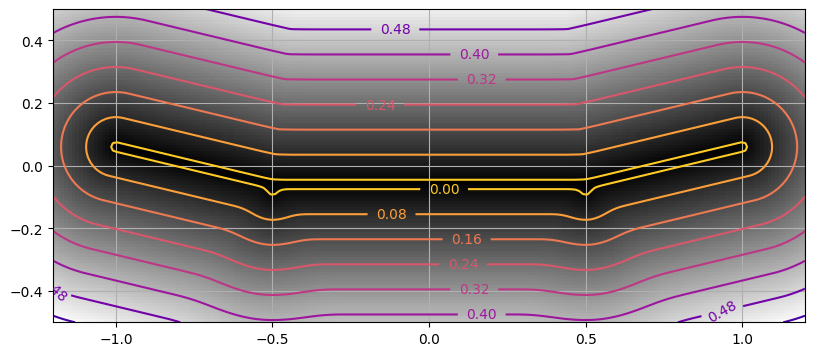

In [15]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, co_resolution[1]//2, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[2]/2, co_size[2]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(field[:, co_resolution[1]//2, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[2] / 2, co_size[2] / 2),
              origin="lower"
              )
    y_mask = coor[1] == 0
    cs = ax.contour(coor[0, y_mask].reshape(co_res_new[0], co_res_new[2]),
                    coor[2, y_mask].reshape(co_res_new[0], co_res_new[2]),
                    field[:, co_resolution[1]//2, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [16]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=plate_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()
